In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from datetime import datetime, date
import quandl

The risk of a portfolio is determined by not only the variance but also the correlations among assets. For a given risk, a rational investor would prefer an allocation with a higher expected returns; On the other hand, for a given return, he or she would prefer the portfolio with a lower risk level. This is a typical dual optimization problem.

Assume we have $n$ 
 assets and their expected return column vector is $\mu$
 and their covariance matrix is $\Sigma$
. Then the return and variance of a portfolio that invests in these n assets with weight $w$
 are, respectively

$$\begin{matrix}
\mu_p &=& w^T\mu \\\\
\sigma_p^2 &=& w^T\Sigma w        
\end{matrix}
$$

In addition, the covariance between two portfolios of respective weights $w_1$
 and $w_2$
, is

$$ \rho_{12}=cov(w_1^T\mu,w_2^T\mu)=w_1^T\Sigma w_2            \tag{1.2}$$

In [5]:
assets = ['AAPL',       # Apple
          'KO',         # Coca-Cola
          'DIS',        # Disney
          'XOM',        # Exxon Mobil
          'JPM',        # JPMorgan Chase
          'MCD',        # McDonald's
          'WMT']         # Walmart
# download historical data from quandl
hist_data = {}
for asset in assets:
    data = quandl.get('wiki/'+asset, start_date='2015-01-01', end_date='2017-12-31', authtoken='ay68s2CUzKbVuy8GAqxj')
    hist_data[asset] = data['Adj. Close']
hist_data = pd.concat(hist_data, axis=1)

# calculate historical log returns
hist_return = np.log(hist_data / hist_data.shift())
hist_return = hist_return.dropna()

# find historical mean, covriance, and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()
print(hist_mean.transpose())
print(hist_cov)
print(hist_corr)

        AAPL       KO       DIS       XOM       JPM       MCD       WMT
mu  0.000619  0.00023  0.000237  0.000007  0.000811  0.000918  0.000269
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  0.000208  0.000032  0.000055  0.000051  0.000076  0.000044  0.000038
KO    0.000032  0.000065  0.000030  0.000033  0.000032  0.000034  0.000031
DIS   0.000055  0.000030  0.000138  0.000048  0.000072  0.000032  0.000031
XOM   0.000051  0.000033  0.000048  0.000132  0.000080  0.000036  0.000029
JPM   0.000076  0.000032  0.000072  0.000080  0.000181  0.000052  0.000038
MCD   0.000044  0.000034  0.000032  0.000036  0.000052  0.000102  0.000032
WMT   0.000038  0.000031  0.000031  0.000029  0.000038  0.000032  0.000150
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  1.000000  0.275779  0.325700  0.309552  0.390836  0.303736  0.213516
KO    0.275779  1.000000  0.317669  0.357156  0.293271  0.423076  0.309700
DIS   0.325700  0.317669  1.000

Now let's use Monte Carlo simulation to contruct 5,000 portfolios with random generated weights 

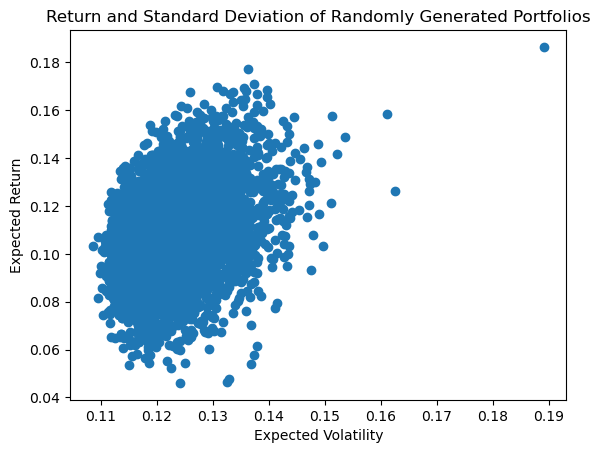

In [11]:
# construct random portfolios
n_portfolios = 5000
#set up array to hold results
port_returns = np.zeros(n_portfolios)
port_stdevs = np.zeros(n_portfolios)

for i in range(n_portfolios):
    w = np.random.rand(len(assets))        # random weights
    w = w / sum(w)                         # weights sum to 1
    port_return = np.dot(w.T, hist_mean.values) * 250         # annualize; 250 business days
    port_stdev = np.sqrt(np.dot(w.T, np.dot(hist_cov, w))) * np.sqrt(250)  # annualize; 250 business days
    port_returns[i] = port_return
    port_stdevs[i] = port_stdev

plt.plot(port_stdevs, port_returns, 'o', markersize=6)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.show()

As you can see, asset allocation makes a difference. Some portfolios are superior to others; achieving higher returns at the cost of lower risks. This is where the professional portfolio managers can add value to. So how to choose a good allocation? We will explore some basic solutions in the following sections.

## Global Minimum Variance (GMV)
Of all the portfolios in figure 1, Global Minimum Variance (GMV) is the far left one. It is the lowest risk one can achieve by holding the seven stocks above. Mathematically, to find the Global Minimum Variance Portfolio, we need to solve

$$\begin{matrix}
\min & \sigma^2=w^T\Sigma w \\\\
s.t. & w^T\mathbf{1} = 1
\end{matrix}            \tag{2.1}$$

The Lagrangian for this problem is

$$ L(w,\lambda)=w^T\Sigma w+\lambda(w^T\mathbf{1}-1)       \tag{2.2}$$
and its first order condition is

$$ \begin{matrix}
\frac{\partial L}{\partial w} &=&w^T(\Sigma +\Sigma^T)+\lambda \mathbf{1}^T &=& 0 \\\\
\frac{\partial L}{\partial \lambda} &=& w^T\mathbf{1} -1 &=& 0
\end{matrix}            \tag{2.3}$$

To solve this system of two equations, first we solve for w from the first equation
$$ w = -\frac{1}{2}\lambda\Sigma^{-1}\mathbf{1}            \tag{2.4} $$
Then we put it into the second equation to solve $ \lambda $
$$ \begin{matrix}
w^T\mathbf{1}&=&(-\frac{1}{2}\lambda \mathbf{1}^T\Sigma^{-1})\mathbf{1}=1 \\\\
 &\Rightarrow& \lambda = -\frac{2}{\mathbf{1}^T\Sigma^{-1}\mathbf{1}}
\end{matrix}                \tag{2.5} $$

Finally substitute $ \lambda$
 back to solve for the optimal $w$

 $$ w^*=\frac{\Sigma^{-1}\mathbf{1}}{\mathbf{1}^T\Sigma^{-1}\mathbf{1}}         \tag{2.6}$$

In [12]:
# Global Minimum Variance (GMV) -- closed form
hist_cov_inv = - np.linalg.inv(hist_cov)
one_vec = np.ones(len(assets))
w_gmv = np.dot(hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(hist_cov_inv, one_vec)))
w_gmv_df = pd.DataFrame(data = w_gmv).transpose()
w_gmv_df.columns = assets
stdev_gmv = np.sqrt(np.dot(w_gmv.T, np.dot(hist_cov, w_gmv))) * np.sqrt(250)
print(w_gmv_df)
print(stdev_gmv)

       AAPL        KO       DIS       XOM       JPM      MCD       WMT
0  0.038996  0.428003  0.122932  0.114705 -0.014062  0.18088  0.128547
0.10759482208087713


In [17]:
# Global Minimum Variance (GMV) -- numerical
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(1.0, (1, len(assets)))
b = matrix(1.0)
w_gmv_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x'])
w_gmv_df_v2 = pd.DataFrame(w_gmv_v2).transpose()
w_gmv_df_v2.columns = assets
stdev_gmv_v2 = np.sqrt(np.dot(w_gmv_v2.T, np.dot(hist_cov, w_gmv_v2))) * np.sqrt(250)
print(w_gmv_df_v2)
print((stdev_gmv_v2)[0][0])

       AAPL        KO       DIS       XOM       JPM      MCD       WMT
0  0.038996  0.428003  0.122932  0.114705 -0.014062  0.18088  0.128547
0.10759482208087713


## Efficient Portfolio
To find an efficient portfolio other than GMV, we face a dual optimization problem. The primary problem finds highest return given a certain risk level $ \sigma_o $

$$ \begin{matrix}
\max & \mu_p=w^T\mu \\\\
s.t. & \sigma_p^2=w^T\Sigma w=\sigma_{o}\\
     & w^T\mathbf{1}=1
\end{matrix}                \tag{3.1}$$

while its dual finds the minimum risk given a certain return level $ \mu_o$

$$\begin{matrix}
\min & \sigma_p^2=w^T\Sigma w \\\\
s.t. & \mu_p=w^T\mu=\mu_{o} \\\\
     & w^T\mathbf{1} = 1
\end{matrix}                \tag{3.2}$$

It is more common to solve the dual minimization problem (3.2), whose Lagrangian function is given by

$$ L(w,\lambda_1, \lambda_2)=w^T\Sigma w + \lambda_1(w^T\mu-\mu_o) + \lambda_2(w^T\mathbf{1}-1)
\tag{3.3} $$

and its first order condition is

$$ \begin{matrix}
2\Sigma w + \lambda_1\mu + \lambda_2 \mathbf{1} &=& 0 \\\\
w^T \mu-\mu_o &=& 0 \\\\
w^T\mathbf{1} - 1 &=& 0
\end{matrix}            \tag{3.4} $$

Similarily, from the first equation we have

$$ w=-\frac{1}{2}\lambda_1\Sigma^{-1}\mu-\frac{1}{2}\lambda_2\Sigma^{-1}\mathbf{1}
\tag{3.5} $$

and put it into the last two equations to get the matrix format of $\lambda=[\lambda_1;\lambda_2]$ as

$$ -\frac{1}{2}\begin{pmatrix} \mu^T\Sigma^{-1}\mu & \mu^T\Sigma^{-1}\mathbf{1} \\\\ \mu^T\Sigma^{-1}\mathbf{1} & \mathbf{1}^T\Sigma^{-1}\mathbf{1} \end{pmatrix} \begin{pmatrix}\lambda_1 \\\\ \lambda_2\end{pmatrix} = \begin{pmatrix}\mu_o \\\\ 1\end{pmatrix}
\tag{3.6} $$

which yeilds
$$ \begin{matrix}
\lambda &=&\begin{pmatrix}\lambda_1 \\\\ \lambda_2 \end{pmatrix}=-2A^{-1}y  \\\\
A &=& \begin{pmatrix} \mu^T\Sigma^{-1}\mu & \mu^T\Sigma^{-1}\mathbf{1} \\\\ \mu^T\Sigma^{-1}\mathbf{1} & \mathbf{1}^T\Sigma^{-1}\mathbf{1} \end{pmatrix} \\\\
y &=& \begin{pmatrix}\mu_o \\\\ 1\end{pmatrix}
\end{matrix}
\tag{3.7} $$
in the end we sub $\lambda$ back to solve for optimal w as
$$ \begin{matrix}
w^*&=&-\frac{1}{2}\Sigma^{-1}B\lambda=\Sigma^{-1}BA^{-1}y \\\\
B&=&[\mu;\mathbf{1}]
\end{matrix}
\tag{3.8}$$

The following code finds minimum risk portfolio with a given return level $\mu_o=max(\mu)$

In [20]:
# Maximum return -- closed form
mu_o = np.max(hist_mean).item()  # MCD
A = np.matrix([[np.dot(hist_mean.T,np.dot(hist_cov_inv,hist_mean)).item(),
                np.dot(hist_mean.T,np.dot(hist_cov_inv,one_vec)).item()],
               [np.dot(hist_mean.T,np.dot(hist_cov_inv,one_vec)).item(),
                np.dot(one_vec.T,np.dot(hist_cov_inv,one_vec))]])
B = np.hstack([np.array(hist_mean),one_vec.reshape(len(assets),1)])
y = np.matrix([mu_o, 1]).T
w_max_ret = np.dot(np.dot(np.dot(hist_cov_inv, B),  np.linalg.inv(A)),y)
w_max_ret_df = pd.DataFrame(w_max_ret).T
w_max_ret_df.columns = assets
print(w_max_ret_df)

       AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.097223  0.183309 -0.010082 -0.235389  0.257571  0.647928  0.059439


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [25]:
# Maximum return -- numerical
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(np.hstack([np.array(hist_mean),one_vec.reshape(len(assets),1)]).transpose())
b = matrix([mu_o,1])
w_max_ret_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x'])
w_max_ret_df_v2 = pd.DataFrame(w_max_ret_v2).transpose()
w_max_ret_df_v2.columns = assets
print(w_max_ret_df_v2)

       AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.097223  0.183309 -0.010082 -0.235389  0.257571  0.647928  0.059439


## Efficient Frontier
The previous section finds the minimum risk portfolio for a given return level. When we traverse all possible return levels, we get a set of optimal portfolios known as efficient frontier.

Alternatively, accordingly to Two_mutual_fund_theorem, it turns out we can construct the efficient frontier as a linear combination of the previous two portfolios, GMV and maximum return.

The code is similar to previous section except for a loop to traverse N target returns.

In [35]:
min(hist_mean.values).item()   

6.831513687771268e-06

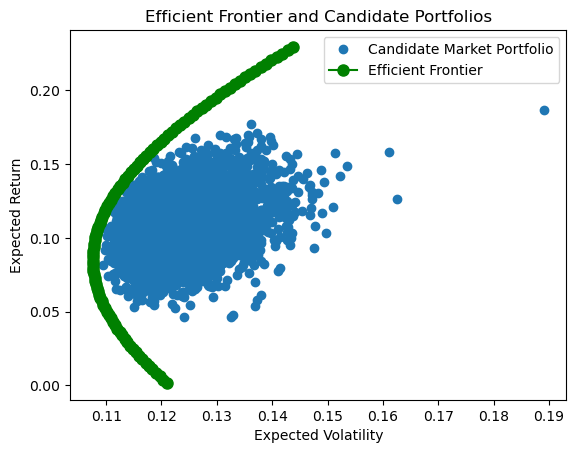

In [37]:
# efficient frontier
N = 100
ef_left = min(hist_mean.values).item()          # minimum return
ef_right = max(hist_mean.values).item()         # maximum return
target_returns = np.linspace(ef_left, ef_right, N)         # N target returns
optimal_weights = [ solvers.qp(P, q, A=A, b=matrix([t,1]))['x'] for t in target_returns ]    # QP solver
ef_returns = [np.dot(w.T, hist_mean.values*250).item() for w in optimal_weights ]         #a nnualized
ef_risks = [np.sqrt(np.dot(w.T, np.dot(hist_cov, w) * 250)).item() for w in optimal_weights ]

plt.plot(port_stdevs, port_returns, 'o', markersize=6, label='Candidate Market Portfolio')
plt.plot(ef_risks, ef_returns, 'y-o', color='green', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Candidate Portfolios')
plt.legend(loc='best')
plt.show()

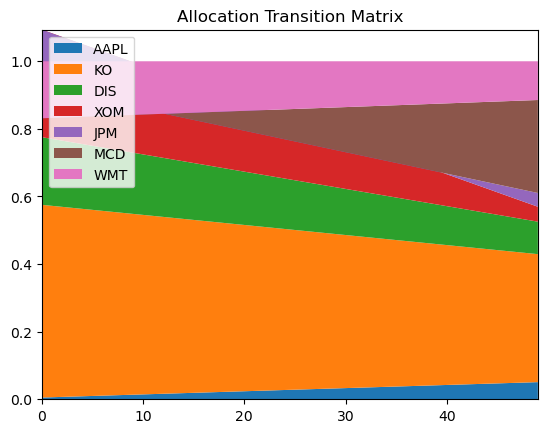

In [42]:
transition_data = pd.DataFrame(optimal_weights)
transition_data.columns = assets
plt.stackplot(range(50), transition_data.iloc[:50,:].T, labels=assets)             # the other half has negative weights
plt.legend(loc='upper left')
plt.margins(0, 0)
plt.title('Allocation Transition Matrix')
plt.show()

The transition figure tells us that for low returns it suffices to hold only five stocks. As we demand higher and higher returns, we start to hold JPM and then DIS.

## Tangency Portfolio
Another interesting portfolio is tangency portfolio that maximizes Sharpe Ratio, one of the most popular measures for performance evaluation.

Denote risk free interest rate as $r_f$
, tangency portfolio targets the following equation,
$$ \begin{matrix}
\max & \frac{\mu_p-r_f}{\sigma_p} = \frac{w^T\mu-r_f}{(w^T\Sigma w)^{\frac{1}{2}}} \\\\
s.t. & w^T\mathbf{1}=1
\end{matrix}
\tag{5.1}$$
Because of the denominator, solve it directly via Lagrangian would be complicated. Fortunately we can be a bit creative and actually take advantage of the division format. Here is the intuitive approach. First, note that the ojective function is invariant with respect to leverage. In other words, it remains the same if we double the weight $w$
. Therefore the constraint can be ignored as long as $w$
 will be normalized in the end.
 Secondly, if we knew the expected return $r_o$
 of the tangent portfolio, it must satisfy the following:
 $$\begin{matrix}
\max & w^T\Sigma w \\\\
s.t. & w^T(\mu-r_f\mathbf{1})=r_o
\end{matrix}
\tag{5.2}$$
Solving this similarily to the previous section, it gives

$$ w=\frac{r_0}{(\mu-r_f\mathbf{1})^T\Sigma^{-1}(\mu-r_f\mathbf{1})}(\Sigma^{-1}(\mu-r_f\mathbf{1}))
\tag{5.3} $$
By normalizing it, the arbitrary target expected return $r_o$
 actually goes away, leaving the optimal allocation as

 $$w^*=\frac{\Sigma^{-1}(\mu-r_f\mathbf{1})}{\mathbf{1}^T\Sigma^{-1}(\mu-r_f\mathbf{1})}
\tag{5.4}$$

In [43]:
# Maximum sharpe -- closed form
r_f = 0.01
w_sharpe = np.dot(hist_cov_inv, hist_mean.values -r_f/250) / np.dot(one_vec, np.dot(hist_cov_inv, hist_mean.values -r_f/250))
w_sharpe_df = pd.DataFrame(w_sharpe).T
w_sharpe_df.columns = assets
mu_sharpe = np.dot(w_sharpe.T, hist_mean.values ) * 250
stdev_sharpe = np.sqrt(np.dot(w_sharpe.T, np.dot(hist_cov, w_sharpe))) * np.sqrt(250)
sharpe_ratio = (mu_sharpe-r_f)/stdev_sharpe
print(w_sharpe_df)
print(mu_sharpe)
print(stdev_sharpe)
print(sharpe_ratio)

       AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.180399 -0.166227 -0.200087 -0.735487  0.645591  1.315091 -0.039281
[[0.43523996]]
[[0.25556683]]
[[1.66390904]]


In [45]:
from scipy.optimize import minimize

fun = lambda w: -1 * np.dot(w.T, hist_mean.values *250-r_f) / np.sqrt(np.dot(w.T, np.dot(hist_cov*250, w)))
cons = ({'type': 'eq', 'fun': lambda w:  np.dot(w.T, one_vec)-1})
res = minimize(fun, w_gmv, method='SLSQP', constraints=cons)
w_sharpe_v2 = res['x']
w_sharpe_v2_df = pd.DataFrame(w_sharpe_v2).T
w_sharpe_v2_df.columns = assets
mu_sharpe_v2 = np.dot(w_sharpe_v2.T, hist_mean.values ) * 250
stdev_sharpe_v2 = np.sqrt(np.dot(w_sharpe_v2.T, np.dot(hist_cov, w_sharpe_v2))) * np.sqrt(250)
sharpe_ratio_v2 = (mu_sharpe-r_f)/stdev_sharpe
print(w_sharpe_v2_df)
print(mu_sharpe_v2)
print(stdev_sharpe_v2)
print(sharpe_ratio_v2)

       AAPL        KO      DIS       XOM       JPM      MCD       WMT
0  0.180333 -0.166332 -0.20005 -0.735362  0.645626  1.31512 -0.039335
[0.43523627]
0.2555646113293455
[[1.66390904]]
